In [2]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
sys.path.append("D:\\Projects\\Python\\Deep learning from scratch")
from common.layers import *
from common.trainer import Trainer
from dataset.mnist import load_mnist
from collections import OrderedDict
# from 

![](../img/im2col.png)
为了加速计算，将滤波器的应用区域从头开始依次横向展开为1列

In [3]:
def im2col(input_data, filter_h, filter_w, stride = 1, pad = 0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride+1
    out_w = (W + 2*pad - filter_w)//stride+1
    # np.pad [(axis0_begin, axis0_end), (axis1_begin, axis1_end), ...]
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y+stride*out_h
        for x in range(filter_w):
            x_max = x+stride*out_w
            col[:,:,y,x,:,:] = img[:,:,y:y_max:stride, x:x_max:stride]        
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1) # transpose 修改多维矩阵轴的顺序
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [4]:
x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) #9, 75

(9, 75)


In [5]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db = None
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1+ (H + 2*self.pad - FH)/ self.stride)
        out_w = int(1+ (W + 2*self.pad - FW)/ self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # FN行，-1维元素个数个列
        
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

In [6]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H-self.pool_h)/self.stride)
        out_w = int(1 + (W-self.pool_w)/self.stride)
        
        # 展开
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        return out 
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape+(pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0]*dmax.shape[1]*dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [7]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                conv_param={'filter_num':30, 'filter_size':5,'pad':0, 'stride':1},
                hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size'] 
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad)/filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2)*(conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0],filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], 
                                           self.params['b1'], 
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        self.loss(x,t)
        dout = 1 
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

train loss:2.2996164215540587
=== epoch:1, train acc:0.168, test acc:0.155 ===
train loss:2.2968998794425555
train loss:2.2937523097991805
train loss:2.286816685122709
train loss:2.2776703730289
train loss:2.2692752072598226
train loss:2.2486723500106236
train loss:2.2289266365153777
train loss:2.2074862595199005
train loss:2.1803087078981718
train loss:2.1215361159009363
train loss:2.102650984352325
train loss:2.055926198494704
train loss:2.0178197130964164
train loss:1.9548602548622307
train loss:1.8488746878376188
train loss:1.8423210252428028
train loss:1.7442572901044542
train loss:1.6620263762223282
train loss:1.5736804943485976
train loss:1.5656543894476542
train loss:1.4380714660675544
train loss:1.4218179702797298
train loss:1.1395287686449866
train loss:1.224864221304266
train loss:1.104967041986366
train loss:1.0842407386226927
train loss:1.04504162329816
train loss:0.9029836832997321
train loss:0.8129144325760019
train loss:0.8148036948481964
train loss:0.9237527381065435
t

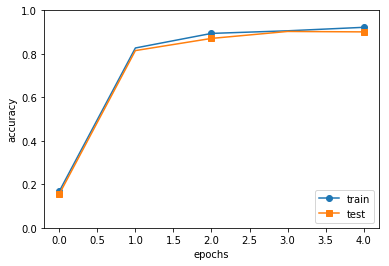

In [8]:
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 5

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
# network.save_params("params.pkl")
# print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()